In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import gamma
import sys
import geopandas as gpd
import datetime
%matplotlib inline

In [2]:
def shift(xs, n):
    if n > 0:
        return np.r_[np.full(n, np.nan), xs[:-n]]
    elif n==0:
        return xs
    else:
        return np.r_[xs[-n:], np.full(-n, np.nan)]

In [3]:
# R_t functions based on known parameters

def generation_time(x):
    return gamma.pdf(x, 1.88, scale=1./0.26)

def R_t(I, t):
    num = I[t]
    den = 0
    for s in range(0,t+1):
        den += I[t-s] * generation_time(s)
    return num/den

In [4]:
def normalized(x, factor = 1, normalized = True):
    if normalized:
        return (x-min(x))/(max(x)-min(x))*factor
    else:
        return x

In [87]:
df_covid = pd.read_csv('data/dpc-covid19-ita-andamento-nazionale.csv', parse_dates = ['data'])
df_covid = df_covid[df_covid['data'] < '2020-12-29']
df_covid['data'] = pd.to_datetime(df_covid['data']).dt.date
df_covid = df_covid.drop(columns = ['casi_da_sospetto_diagnostico', 'casi_da_screening', 'tamponi', 'casi_testati', 'note', 'ingressi_terapia_intensiva', 
                                   'note_test', 'note_casi', 'totale_positivi_test_molecolare', 'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
                                   'tamponi_test_antigenico_rapido', 'ricoverati_con_sintomi', 'terapia_intensiva', 'stato', 'isolamento_domiciliare',
                                   'totale_ospedalizzati', 'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi'])

#df_covid['recovered_death'] = df_covid['dimessi_guariti'] + df_covid['deceduti']
#df_covid = df_covid.reset_index()
xdata = df_covid['data']
start_day = xdata[0]
end_day = xdata[len(xdata)-1]
df_covid.index = df_covid['data']
df_covid = df_covid.drop(columns=['data'])

In [88]:
I = df_covid['totale_positivi']
#R = df_covid['recovered_death']
#N = 9981554

# Comparison with R_t diverso

In [7]:
# R_t ISS usando covidstat
Rt_iss = pd.read_csv('data/iss/iss_rt_italia.csv',  parse_dates = ['data'])
Rt_iss = Rt_iss.dropna()
Rt_iss = Rt_iss.set_index('data')
Rt_iss = Rt_iss[start_day:end_day]
Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici', 'rt_sintomatici_err68perc'])

In [8]:
# # R_t evaluation using Cori et al
# R_t_list = []
# for t in range(7,len(xdata)):
#     R_t(I, t)
#     R_t_list.append(R_t(I, t))

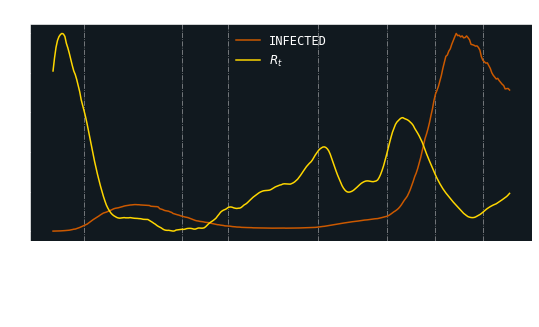

In [11]:
fig, ax = plt.subplots(1,1, figsize=(9, 4), facecolor='#11191F')
fig.patch.set_alpha(0.0)
ax.set_facecolor(('#11191F'))
ax.tick_params(color='#FFFFFF', labelcolor='#FFFFFF')
for spine in ax.spines.values():
        spine.set_edgecolor('#FFFFFF')

ax.set_title('INFECTED AND $R_t$', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')

plt.plot(normalized(df_covid['totale_positivi']), '#CC5900', markersize=5)
plt.plot(normalized(Rt_iss['rt_positivi']), 'gold', markersize=5)
#plt.title('Infected in Italy 2020, fit and Rt', color = '#FFFFFF')
ax.legend(['INFECTED', '$R_t$'], framealpha = 0, labelcolor = '#FFFFFF', prop = {'size':12,'family':'monospace'})
plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 35,
    fontsize=8, fontname='monospace')
plt.yticks(fontsize=10)
ax.grid(axis='x', color = '#FFFFFF', linestyle='-.', alpha = 0.5)
plt.savefig("fig/infected_rt.png", bbox_inches = 'tight', dpi=300)
plt.show()

# R_t e mobility

In [5]:
region_names = np.array(['Italy'])
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

In [16]:
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
for name in names:
    values = []
    shifts = []
        
    Rt_iss = pd.read_csv('data/iss/iss_rt_'+'italia'+'.csv')
    Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici','rt_sintomatici_err68perc'])
    Rt_iss = Rt_iss.rename(columns={"data": "date"})

    df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
    df = df[df['sub_region_1'].isnull()]
    df = df.drop(columns=['sub_region_1','sub_region_2', 'country_region_code', 'country_region','sub_region_2','metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])

    df_region = pd.merge(Rt_iss, df)
    df_region = df_region.dropna()
    df_region['date'] = pd.to_datetime(df_region['date'])
    df_region = df_region.reset_index()
    xdata = df_region['date'].dt.date

    ydata = df_region[name]
    Rt_iss = np.array(df_region['rt_positivi'])
    data_index = ydata.index

    ydata = normalized(ydata)
    Rt_iss = normalized(Rt_iss)

    # Togliere outlier da mobility
    rolling_median = ydata.rolling(window=7).median()
    rolling_std = ydata.rolling(window=7).std()
    diff = ydata - rolling_median

    to_drop = []
    for i in range(len(ydata)):
        if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
            to_drop.append(i)

    ydata_new = np.array(ydata)
    rolling_median_new = np.array(rolling_median)
    xdata_new = np.array(xdata)
    Rt_iss_new = np.array(Rt_iss)

    ydata_new = np.delete(ydata_new, to_drop)
    rolling_median_new = np.delete(rolling_median_new, to_drop)
    xdata_new = np.delete(xdata_new, to_drop)
    Rt_iss_new = np.delete(Rt_iss_new, to_drop)

    correlations = []
    # Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
    # questi sono per i -20 a 0
    for i in range(-30, 0, 1):
        mob_sh = shift(ydata_new, i)
        mob_sh = mob_sh[~np.isnan(mob_sh)]
        correlations.append(stats.spearmanr(mob_sh, Rt_iss_new[:len(mob_sh)])[0])
    # questo per 0, 20
    for i in range(0, 31, 1):
        i_sh = shift(Rt_iss_new, -i)
        i_sh = i_sh[~np.isnan(i_sh)]
        correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
    mi = np.min(correlations)
    ma = np.max(correlations)
    if np.abs(mi) > ma:
        values.append(np.min(correlations))
        shifts.append(np.arange(-30,31)[np.argmin(correlations)])
    else:
        values.append(np.max(correlations))
        shifts.append(np.arange(-30,31)[np.argmax(correlations)])
    region_report[name] = values
    region_report[name[:5] + 'shifts'] = shifts

In [17]:
region_report

,region_name,retail_and_recreation_percent_change_from_baseline,retaishifts,grocery_and_pharmacy_percent_change_from_baseline,groceshifts,parks_percent_change_from_baseline,parksshifts,transit_stations_percent_change_from_baseline,transshifts,workplaces_percent_change_from_baseline,workpshifts,residential_percent_change_from_baseline,residshifts
0,Italy,0.849453,16,0.837236,11,0.843494,23,0.932725,13,0.676091,9,-0.906359,19


# I e mobility

In [20]:
pd.read_csv('data/dpc-covid19-ita-andamento-nazionale.csv', parse_dates = ['data']).head(5)

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
for name in names:
    values = []
    shifts = []
        
    df_covid = pd.read_csv('data/dpc-covid19-ita-andamento-nazionale.csv', parse_dates = ['data'])
    df_covid['data'] = pd.to_datetime(df_covid['data']).dt.strftime('%Y-%m-%d')
    df_covid = df_covid.drop(columns = ['casi_da_sospetto_diagnostico', 'casi_da_screening', 'tamponi', 'casi_testati', 'note', 'ingressi_terapia_intensiva', 
                                       'note_test', 'note_casi', 'totale_positivi_test_molecolare', 'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
                                       'tamponi_test_antigenico_rapido', 'ricoverati_con_sintomi', 'terapia_intensiva', 'stato', 'isolamento_domiciliare',
                                       'totale_ospedalizzati',
                                       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi'])
    df_covid = df_covid.rename(columns={"data": "date"})
    
    df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
    df = df[df['sub_region_1'].isnull()]
    df = df.drop(columns=['sub_region_1','sub_region_2', 'country_region_code', 'country_region','sub_region_2','metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])

    df_region = pd.merge(df_covid, df)
    df_region = df_region.dropna()
    df_region['date'] = pd.to_datetime(df_region['date'])
    df_region = df_region.reset_index()
    xdata = df_region['date'].dt.date

    ydata = df_region[name]
    Rt_iss = np.array(df_region['totale_positivi'])
    data_index = ydata.index

    ydata = normalized(ydata)
    Rt_iss = normalized(Rt_iss)

    # Togliere outlier da mobility
    rolling_median = ydata.rolling(window=7).median()
    rolling_std = ydata.rolling(window=7).std()
    diff = ydata - rolling_median

    to_drop = []
    for i in range(len(ydata)):
        if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
            to_drop.append(i)

    ydata_new = np.array(ydata)
    rolling_median_new = np.array(rolling_median)
    xdata_new = np.array(xdata)
    Rt_iss_new = np.array(Rt_iss)

    ydata_new = np.delete(ydata_new, to_drop)
    rolling_median_new = np.delete(rolling_median_new, to_drop)
    xdata_new = np.delete(xdata_new, to_drop)
    Rt_iss_new = np.delete(Rt_iss_new, to_drop)

    correlations = []
    # Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
    # questi sono per i -20 a 0
    for i in range(-15, 0, 1):
        mob_sh = shift(ydata_new, i)
        mob_sh = mob_sh[~np.isnan(mob_sh)]
        correlations.append(stats.spearmanr(mob_sh, Rt_iss_new[:len(mob_sh)])[0])
    # questo per 0, 20
    for i in range(0, 16, 1):
        i_sh = shift(Rt_iss_new, -i)
        i_sh = i_sh[~np.isnan(i_sh)]
        correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
    mi = np.min(correlations)
    ma = np.max(correlations)
    if np.abs(mi) > ma:
        values.append(np.min(correlations))
        shifts.append(np.arange(-15,16)[np.argmin(correlations)])
    else:
        values.append(np.max(correlations))
        shifts.append(np.arange(-15,16)[np.argmax(correlations)])
    region_report[name] = values
    region_report[name[:5] + 'shifts'] = shifts

In [23]:
region_report

,region_name,retail_and_recreation_percent_change_from_baseline,retaishifts,grocery_and_pharmacy_percent_change_from_baseline,groceshifts,parks_percent_change_from_baseline,parksshifts,transit_stations_percent_change_from_baseline,transshifts,workplaces_percent_change_from_baseline,workpshifts,residential_percent_change_from_baseline,residshifts
0,Italy,-0.649039,1,-0.143027,1,-0.624417,2,-0.491157,0,-0.176701,0,0.618762,1


# I e R_t

# K e mobility

In [28]:
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']
average_network_degree = pd.read_csv('data/italy_mobility/average_network_degree_2020_01_18_2020_06_26.csv').drop(columns = ['Unnamed: 0', 'COD_PROV', 'NAME_PROV', 'SIGLA'])

In [52]:
region_report = pd.DataFrame(region_names, columns = ['region_name'])
for name in names:
    values = []
    shifts = []
        
    #df_k = prova[region_names_italian[r][0].upper()+region_names_italian[r][1:]].rename('k')
    df_k = pd.DataFrame(average_network_degree.mean().to_dict(),index=[df.index.values[-1]]).T
    df_k = df_k.rename(columns={320:'k'})
    df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
    df = df[df['sub_region_1'].isnull()]
    #df = df[df['sub_region_2'].isnull()]
    df = df.drop(columns=['sub_region_1','sub_region_2', 'country_region_code', 'country_region','sub_region_2','metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])

    df_region = pd.merge(df_k, df, left_index = True, right_on = 'date')
    df_region = df_region.dropna()
    df_region['date'] = pd.to_datetime(df_region['date'])
    df_region = df_region.reset_index()
    df_region = df_region.drop(columns = ['index'])
    df_region['k'] = df_region['k'].astype(np.float64)
    xdata = df_region['date'].dt.date

    ydata = df_region[name]
    #Rt_iss = np.array(df_region['k'])
    Rt_iss = df_region['k']
    data_index = ydata.index

    ydata = normalized(ydata)
    Rt_iss = normalized(Rt_iss)

    # Togliere outlier da mobility
    rolling_median = ydata.rolling(window=7).median()
    rolling_std = ydata.rolling(window=7).std()

    # Togliere outlier da k
    rolling_median_k = Rt_iss.rolling(window=7).median()
    rolling_std_k = Rt_iss.rolling(window=7).std()

    to_drop = []
    for i in range(len(ydata)):
        if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
            to_drop.append(i)

    to_drop_k = []
    for i in range(len(Rt_iss)):
        if (Rt_iss[i] > rolling_median_k[i] + 1*rolling_std_k[i]) | (Rt_iss[i] < rolling_median_k[i] - 1*rolling_std_k[i]):
            to_drop_k.append(i)

    to_drop = to_drop + to_drop_k       

    ydata_new = np.array(ydata)
    xdata_new = np.array(xdata)
    Rt_iss_new = np.array(Rt_iss)

    ydata_new = np.delete(ydata_new, to_drop)
    xdata_new = np.delete(xdata_new, to_drop)
    Rt_iss_new = np.delete(Rt_iss_new, to_drop)


    correlations = []
    correlations.append(stats.spearmanr(Rt_iss_new, ydata_new)[0])
    values.append(stats.spearmanr(Rt_iss_new, ydata_new)[0])
        
    region_report[name] = values

In [53]:
region_report

,region_name,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Italy,0.949522,0.940357,0.884972,0.962267,0.959614,-0.944198


# k e R_t 
Ora fare la stessa cosa ma con questi dati ed R_t. Bisogna cambiare un po' il codice

Questa volta abbiamo preso dati solo fino alla fine del primo lockdown (4 maggio), perché dopo i contatti sono ripartiti ma l'indice r_t è rimasto basso.

In [55]:
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']
average_network_degree = pd.read_csv('data/italy_mobility/average_network_degree_2020_01_18_2020_06_26.csv').drop(columns = ['Unnamed: 0', 'COD_PROV', 'NAME_PROV', 'SIGLA'])

In [56]:
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

In [60]:
values = []
shifts = []

df_k = pd.DataFrame(average_network_degree.mean().to_dict(),index=[df.index.values[-1]]).T
df_k = df_k.rename(columns={320:'k'})

Rt_iss = pd.read_csv('data/iss/iss_rt_'+'italia'+'.csv')
Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici','rt_sintomatici_err68perc'])
Rt_iss = Rt_iss.rename(columns={"data": "date"})

df_region = pd.merge(df_k, Rt_iss, left_index = True, right_on = 'date')
df_region = df_region.dropna()
df_region['date'] = pd.to_datetime(df_region['date'])
df_region = df_region.reset_index()
df_region = df_region.drop(columns = ['index'])
df_region['k'] = df_region['k'].astype(np.float64)

# Proviamo a prendere fino alla fine del lockdown
df_region = df_region[df_region['date']<'2020-05-04']
xdata = df_region['date'].dt.date

ydata = df_region['k']
Rt_iss = np.array(df_region['rt_positivi'])
data_index = ydata.index

ydata = normalized(ydata)
Rt_iss = normalized(Rt_iss)

# Togliere outlier da mobility
rolling_median = ydata.rolling(window=3).mean()
rolling_std = ydata.rolling(window=3).std()
diff = ydata - rolling_median

to_drop = []
for i in range(len(ydata)):
    if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
        to_drop.append(i)

ydata_new = np.array(ydata)
rolling_median_new = np.array(rolling_median)
xdata_new = np.array(xdata)
Rt_iss_new = np.array(Rt_iss)

ydata_new = np.delete(ydata_new, to_drop)
rolling_median_new = np.delete(rolling_median_new, to_drop)
xdata_new = np.delete(xdata_new, to_drop)
Rt_iss_new = np.delete(Rt_iss, to_drop)

# plt.plot(ydata_new)
# plt.plot(Rt_iss_new)
# plt.show()


correlations = []
# Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
# questi sono per i -20 a 0
for i in range(-15, 0, 1):
    mob_sh = shift(ydata_new, i)
    mob_sh = mob_sh[~np.isnan(mob_sh)]
    correlations.append(stats.spearmanr(mob_sh, Rt_iss_new[:len(mob_sh)])[0])
# questo per 0, 20
for i in range(0, 16, 1):
    i_sh = shift(Rt_iss_new, -i)
    i_sh = i_sh[~np.isnan(i_sh)]
    correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
mi = np.min(correlations)
ma = np.max(correlations)

if np.abs(mi) > ma:
    values.append(np.min(correlations))
    shifts.append(np.arange(-15,16)[np.argmin(correlations)])
else:
    values.append(np.max(correlations))
    shifts.append(np.arange(-15,16)[np.argmax(correlations)])
region_report['correlations'] = values
region_report['correlations shifts'] = shifts

In [61]:
region_report

,NOME_REG,correlations,correlations shifts
0,Italy,0.797287,12


# Radius e R_t

In [62]:
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

In [85]:
prova  = pd.read_csv('data/italy_mobility/median_q1_q3_rog_2020_01_18_2020_06_26.csv').drop(columns = ['COD_PROV', 'DEN_PCM', 'SIGLA','18/01-24/01_Q1', '25/01-31/01_Q1', '01/02-07/02_Q1',
       '08/02-14/02_Q1', '15/02-21-02_Q1', '22/02-28/02_Q1', '29/02-06/03_Q1',
       '07/03-13/03_Q1', '14/03-20/03_Q1', '21/03-27/03_Q1', '28-03/03-04_Q1',
       '04-04/10-04_Q1', '11/04-17/04_Q1', '18/04-24/04_Q1', '25/04-01/05_Q1',
       '02/05-08/05_Q1', '09/05-15/05_Q1', '16/05-22/05_Q1', '23/05-29/05_Q1',
       '30/05-05/06_Q1', '06/06-12/06_Q1', '13/06-19/06_Q1', '20/06-26/06_Q1',
       '18/01-24/01_Q3', '25/01-31/01_Q3', '01/02-07/02_Q3', '08/02-14/02_Q3',
       '15/02-21-02_Q3', '22/02-28/02_Q3', '29/02-06/03_Q3', '07/03-13/03_Q3',
       '14/03-20/03_Q3', '21/03-27/03_Q3', '28-03/03-04_Q3', '04-04/10-04_Q3',
       '11/04-17/04_Q3', '18/04-24/04_Q3', '25/04-01/05_Q3', '02/05-08/05_Q3',
       '09/05-15/05_Q3', '16/05-22/05_Q3', '23/05-29/05_Q3', '30/05-05/06_Q3',
       '06/06-12/06_Q3', '13/06-19/06_Q3', '20/06-26/06_Q3'])

df_k = pd.DataFrame(prova.mean().to_dict(),index=[df.index.values[-1]]).T
df_k = df_k.rename(columns={320:'k'})

#new_header = np.array(radius.iloc[0]).astype(str)
#new_header = np.insert(new_header, 0,'date')
#radius = radius[1:]
df_k = df_k.reset_index(level=0)
# radius.columns = new_header
# radius = radius[:17]
df_k = df_k.loc[df_k.index.repeat(7)]

df_k

,index,k
0,18/01-24/01,3.272190
0,18/01-24/01,3.272190
0,18/01-24/01,3.272190
0,18/01-24/01,3.272190
0,18/01-24/01,3.272190
...,...,...
22,20/06-26/06,3.495217
22,20/06-26/06,3.495217
22,20/06-26/06,3.495217
22,20/06-26/06,3.495217


In [90]:
values = []
shifts = []
for r in range(len(region_names)):
    df_k = pd.read_csv('data/italy_mobility/median_q1_q3_rog_2020_01_18_2020_06_26.csv').drop(columns = ['COD_PROV', 'DEN_PCM', 'SIGLA','18/01-24/01_Q1', '25/01-31/01_Q1', '01/02-07/02_Q1',
       '08/02-14/02_Q1', '15/02-21-02_Q1', '22/02-28/02_Q1', '29/02-06/03_Q1',
       '07/03-13/03_Q1', '14/03-20/03_Q1', '21/03-27/03_Q1', '28-03/03-04_Q1',
       '04-04/10-04_Q1', '11/04-17/04_Q1', '18/04-24/04_Q1', '25/04-01/05_Q1',
       '02/05-08/05_Q1', '09/05-15/05_Q1', '16/05-22/05_Q1', '23/05-29/05_Q1',
       '30/05-05/06_Q1', '06/06-12/06_Q1', '13/06-19/06_Q1', '20/06-26/06_Q1',
       '18/01-24/01_Q3', '25/01-31/01_Q3', '01/02-07/02_Q3', '08/02-14/02_Q3',
       '15/02-21-02_Q3', '22/02-28/02_Q3', '29/02-06/03_Q3', '07/03-13/03_Q3',
       '14/03-20/03_Q3', '21/03-27/03_Q3', '28-03/03-04_Q3', '04-04/10-04_Q3',
       '11/04-17/04_Q3', '18/04-24/04_Q3', '25/04-01/05_Q3', '02/05-08/05_Q3',
       '09/05-15/05_Q3', '16/05-22/05_Q3', '23/05-29/05_Q3', '30/05-05/06_Q3',
       '06/06-12/06_Q3', '13/06-19/06_Q3', '20/06-26/06_Q3'])
    
    df_k = pd.DataFrame(prova.mean().to_dict(),index=[df.index.values[-1]]).T
    df_k = df_k.rename(columns={320:'k'})

    df_k = pd.DataFrame(prova.mean().to_dict(),index=[df.index.values[-1]]).T
    df_k = df_k.rename(columns={320:'k'})
    df_k = df_k.reset_index(level=0)
    df_k = df_k.loc[df_k.index.repeat(7)]
    
    Rt_iss = pd.read_csv('data/iss/iss_rt_'+'italia'+'.csv')
    Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici','rt_sintomatici_err68perc'])
    Rt_iss = Rt_iss.rename(columns={"data": "date"})
    Rt_iss['date'] = pd.to_datetime(Rt_iss['date'])
    Rt_iss = Rt_iss.dropna().reset_index()
    Rt_iss = Rt_iss.drop(columns = ['index'])
    
    date_between = []
    start_date = datetime.datetime.strptime('2020-01-18','%Y-%m-%d').date()
    end_date = datetime.datetime.strptime('2020-06-26','%Y-%m-%d').date()
    delta = end_date - start_date   # returns timedelta

    for i in range(delta.days + 1):
        day = start_date + datetime.timedelta(days=i)
        date_between.append(day)
        
    end_date = date_between[-1]
    start_date = pd.to_datetime(Rt_iss['date'][0]).date()
    df_k['date_between'] = date_between
    df_k = df_k[df_k['date_between'] >= start_date]
    idx_0 = df_k.index[0]
    idx_1 = df_k.index[-1]
    
    df_k = df_k[idx_0:idx_1]
    # fatto, ora raggruppiamo gli rt per settimana
    Rt_iss = Rt_iss[Rt_iss['date'].dt.date < end_date ]
    Rt_iss = Rt_iss.groupby(pd.Grouper(key='date', axis=0, freq='7D'))['rt_positivi'].mean()
    Rt_iss = Rt_iss[:len(df_k)]
    #df_k[region_names_italian[r][0].upper()+region_names_italian[r][1:]] = radius[region_names_italian[r][0].upper()+region_names_italian[r][1:]].astype(np.float64)
    df_k = df_k.reset_index()
    
    Rt_iss = np.array(Rt_iss)
    ydata = df_k['k']
    
    ydata = normalized(ydata)
    Rt_iss = normalized(Rt_iss)
    
    # Togliere outlier da mobility
    rolling_median = ydata.rolling(window=1).median()
    rolling_std = ydata.rolling(window=1).std()
    diff = ydata - rolling_median

    to_drop = []
    for i in range(len(ydata)):
        if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
            to_drop.append(i)

    ydata_new = np.array(ydata)
    rolling_median_new = np.array(rolling_median)
    xdata_new = np.array(xdata)
    Rt_iss_new = np.array(Rt_iss)

    ydata_new = np.delete(ydata_new, to_drop)
    rolling_median_new = np.delete(rolling_median_new, to_drop)
    xdata_new = np.delete(xdata_new, to_drop)
    Rt_iss_new = np.delete(Rt_iss, to_drop)
  
    correlations = []
    # Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
    # questi sono per i -20 a 0
    for i in range(-1, 0, 1):
        mob_sh = shift(ydata_new, i)
        mob_sh = mob_sh[~np.isnan(mob_sh)]
        correlations.append(stats.spearmanr(mob_sh, Rt_iss_new[:len(mob_sh)])[0])
    # questo per 0, 20
    for i in range(0, 4, 1):
        i_sh = shift(Rt_iss_new, -i)
        i_sh = i_sh[~np.isnan(i_sh)]
        correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
    mi = np.min(correlations)
    ma = np.max(correlations)

    if np.abs(mi) > ma:
        values.append(np.min(correlations))
        shifts.append(np.arange(-1,4)[np.argmin(correlations)])
    else:
        values.append(np.max(correlations))
        shifts.append(np.arange(-1,4)[np.argmax(correlations)])
        
region_report['correlations'] = values
region_report['correlations shifts'] = shifts

In [91]:
region_report

,region_name,correlations,correlations shifts
0,Italy,0.811679,-1


# mobility e radius

In [ ]:
region_report = pd.DataFrame(region_names, columns = ['region_name'])

for name in names:
    values = []
    shifts = []
    for r in range(len(region_names)):
        median_q1_q3 = pd.read_csv('data/italy_mobility/median_q1_q3_rog_2020_01_18_2020_06_26.csv')
        regioni = pd.read_csv('data/italy_mobility/province-italiane.csv', delimiter=';')
        regioni = regioni.drop(columns=['Provincia'])

        radius = pd.merge(median_q1_q3, regioni, how='inner', left_on = 'SIGLA', right_on = 'Sigla').drop(columns=['Sigla', 'COD_PROV', 'DEN_PCM', 'SIGLA'])
        radius.loc[radius['Regione'] == "Valle d'Aosta", 'Regione'] = 'Aosta'
        radius.loc[radius['Regione'] == "Emilia Romagna", 'Regione'] = 'Emilia_romagna'
        radius.loc[radius['Regione'] == "Trentino Alto Adige", 'Regione'] = 'Trentino_alto_adige'
        radius.loc[radius['Regione'] == "Friuli Venezia Giulia", 'Regione'] = 'Friuli_venezia_giulia'
        radius = radius.groupby('Regione', as_index=False, sort=False)[radius.columns[:-47]].mean()
        radius = radius[radius['Regione'] == region_names_italian[r][0].upper()+region_names_italian[r][1:]].T
        new_header = np.array(radius.iloc[0]).astype(str)
        new_header = np.insert(new_header, 0,'date')
        radius = radius[1:]
        radius = radius.reset_index(level=0)
        radius.columns = new_header
        radius = radius[:17]
        radius_dup = radius.loc[radius.index.repeat(7)]



        Rt_iss = pd.read_csv('data/iss/iss_rt_'+region_names_italian[r]+'.csv')
        Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici','rt_sintomatici_err68perc'])
        Rt_iss = Rt_iss.rename(columns={"data": "date"})
        Rt_iss['date'] = pd.to_datetime(Rt_iss['date'])
        Rt_iss = Rt_iss.dropna().reset_index()
        Rt_iss = Rt_iss.drop(columns = ['index'])

        date_between = []
        start_date = datetime.datetime.strptime('2020-01-18','%Y-%m-%d').date()
        end_date = datetime.datetime.strptime('2020-05-15','%Y-%m-%d').date()
        delta = end_date - start_date   # returns timedelta

        for i in range(delta.days + 1):
            day = start_date + datetime.timedelta(days=i)
            date_between.append(day)
        end_date = date_between[-1]
        start_date = pd.to_datetime(Rt_iss['date'][0]).date()
        radius_dup['date_between'] = date_between
        radius_dup = radius_dup[radius_dup['date_between'] >= start_date]
        idx_0 = radius_dup.index[0]
        idx_1 = radius_dup.index[-1]

        radius = radius[idx_0:idx_1]
        # fatto, ora raggruppiamo gli rt per settimana
        Rt_iss = Rt_iss[Rt_iss['date'].dt.date < end_date ]
        Rt_iss = Rt_iss.groupby(pd.Grouper(key='date', axis=0, freq='7D'))['rt_positivi'].mean()
        Rt_iss = Rt_iss[:len(radius)]
        radius[region_names_italian[r][0].upper()+region_names_italian[r][1:]] = radius[region_names_italian[r][0].upper()+region_names_italian[r][1:]].astype(np.float64)
        radius = radius.reset_index()

        Rt_iss = np.array(Rt_iss)
        ydata = radius[region_names_italian[r][0].upper()+region_names_italian[r][1:]]

        ydata = normalized(ydata)
        Rt_iss = normalized(Rt_iss)

        # Togliere outlier da mobility
        rolling_median = ydata.rolling(window=3).median()
        rolling_std = ydata.rolling(window=3).std()
        diff = ydata - rolling_median

        to_drop = []
        for i in range(len(ydata)):
            if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
                to_drop.append(i)

        ydata_new = np.array(ydata)
        rolling_median_new = np.array(rolling_median)
        xdata_new = np.array(xdata)
        Rt_iss_new = np.array(Rt_iss)

        ydata_new = np.delete(ydata_new, to_drop)
        rolling_median_new = np.delete(rolling_median_new, to_drop)
        xdata_new = np.delete(xdata_new, to_drop)
        Rt_iss_new = np.delete(Rt_iss, to_drop)

        correlations = []
        # Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
        # questi sono per i -20 a 0
        for i in range(-3, 0, 1):
            mob_sh = shift(ydata_new, i)
            mob_sh = mob_sh[~np.isnan(mob_sh)]
            correlations.append(stats.spearmanr(mob_sh, Rt_iss_new[:len(mob_sh)])[0])
        # questo per 0, 20
        for i in range(0, 4, 1):
            i_sh = shift(Rt_iss_new, -i)
            i_sh = i_sh[~np.isnan(i_sh)]
            correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
        mi = np.min(correlations)
        ma = np.max(correlations)

        if np.abs(mi) > ma:
            values.append(np.min(correlations))
            shifts.append(np.arange(-3,4)[np.argmin(correlations)])
        else:
            values.append(np.max(correlations))
            shifts.append(np.arange(-3,4)[np.argmax(correlations)])

    region_report['correlations'] = values
    region_report['correlations shifts'] = shifts